### Model Governance Notebook for models with and without the GLLD feature - OOT Apr
with and without `giact_last_link_date`

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import scale_scores
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

In [2]:
with open('../../models/customer_risk_target_from_gitlab.pkl', 'rb') as f:
    model_w_glld = pickle.load(f)
    
with open('../../models/customer_risk_target_no_giact_time_since_last_link.pkl', 'rb') as f:
    model_wo_glld = pickle.load(f)

### Data Processing

In [3]:
from collections import defaultdict

def encode_defaults(df, default_values):
    """Replace default values with NaN, int encode them"""
    default_encoded_cols = []
    for k, (v, encode) in default_values.items():
        cname = k + '_default_encoded'

        if isinstance(v, pd.Interval):
            is_default = ~df[k].between(v.left, v.right) & ~df[k].isna()
        elif isinstance(v, list):
            is_default = df[k].isin(k)
        else:
            raise RuntimeError('Data type {} not supported'.format(str(type(v))))
        
        if ~is_default.isna().all():
            if encode:
                default_encoded_cols.append(cname)
                df.loc[is_default, cname] = is_default * df[k]
            df.loc[is_default, k] = np.nan #set default values to NaN
        
    return df, default_encoded_cols


cols_raw = ['first_deposit_amount', 'vantage_score', 'bcc7120', 'email_risk_score', 
            'fraud_score_2', 'name_email_correlation', 'transaction_as_pct_of_balance', 
            'mean_account_balance_30d', 'phone_risk_score', 'giact_time_since_last_link', 
            'name_address_correlation', 'all8220', 'lag_acc_open_first_transaction', 
            'dollar_val_dd', 'all7120', 'sum_deposits_10d', 'nr_past_transactions', 
            'total_tradelines_open', 'education_loan_amount', 'address_risk_score',
            'iqt9415', 'max_withdrawals_30d', 'iln5520', 'max_deposits_30d', 
            'pct_returned_deposits', 'giact_nr_decline', 'nr_direct_deposits', 
            'time_since_last_transaction', 'bal_ratio', 'name_phone_correlation', 
            'giact_nr_other', 'dollar_val_returns', 'nr_trans_ratio', 'iqt9413', 
            'dollar_val_returns_3d', 'nr_returns_30d', 'credit_card_loan_amount',
            'fraud_score_1', 'age_money_account']

cols_raw_ni = ['transaction_code']

cols_encoded = ['transaction_code_encoded', 'all7120_default_encoded', 'bcc7120_default_encoded']

features = cols_raw + cols_encoded

default_values = {
    'vantage_score': [pd.Interval(300, 850), False],
    'all7120': [pd.Interval(0, 990), True],
    'all8220': [pd.Interval(0, 9990), False],
    'bcc7120': [pd.Interval(0, 990), True],
    'iln5520': [pd.Interval(0, 999999990), False],
    'iqt9413': [pd.Interval(0, 90), False]
}

def preprocess(df):
    """
    Code to preprocess model.
    """
    # mapping from transaction code to integer
    tcode_map = defaultdict(int,
                            {'POSDW': 1,
                             'ACHDD': 2,
                             'ACHDWIN': 3,
                             'ACHDDIN': 4,
                             'ACHDW': 5,
                             'ACHINDD': 6,
                             'DDATMREFUND': 7,
                             'DWATM': 8,
                             'DDRAFNEW':9,
                             'DDCK': 10})

    df['transaction_code_encoded'] = df['transaction_code'].map(tcode_map)
    
    # clip to handle infinite values and outliers
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].clip(-750, 750)
    df['bal_ratio'] = df['bal_ratio'].clip(-750, 750)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].clip(0, 100)

    # fill na here with 0, can't be NaN just indicates lack of data
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].fillna(0)
    df['max_withdrawals_30d'] = df['max_withdrawals_30d'].fillna(0)
    df['max_deposits_30d'] = df['max_deposits_30d'].fillna(0)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].fillna(0)
    df['bal_ratio'] = df['bal_ratio'].fillna(0)
    df['sum_deposits_10d'] = df['sum_deposits_10d'].fillna(0)
    df['mean_account_balance_30d'] = df['mean_account_balance_30d'].fillna(0)
    df['dollar_val_dd'] = df['dollar_val_dd'].fillna(0) 
    df['nr_direct_deposits'] = df['nr_direct_deposits'].fillna(0)
    df['nr_past_transactions'] = df['nr_past_transactions'].fillna(0)
    df['dollar_val_returns'] = df['dollar_val_returns'].fillna(0)
    df['dollar_val_returns_3d'] = df['dollar_val_returns_3d'].fillna(0)
    df['nr_returns_30d'] = df['nr_returns_30d'].fillna(0)

    # fill na here with -1 indicating that this is the first ever transaction/giact never linked
    df['time_since_last_transaction'] = df['time_since_last_transaction'].fillna(-1)
    df['giact_time_since_last_link'] = df['giact_time_since_last_link'].fillna(-1)
    df['giact_nr_decline'] = df['giact_nr_decline'].fillna(-1)
    df['giact_nr_other'] = df['giact_nr_other'].fillna(-1)
    df['nr_trans_ratio'] = df['nr_trans_ratio'].fillna(-1)
    df['first_deposit_amount'] = df['first_deposit_amount'].fillna(-1)
    df['lag_acc_open_first_transaction'] = df['lag_acc_open_first_transaction'].fillna(-1)
    
    df, _ = encode_defaults(df, default_values)
    
    df['all7120_default_encoded'] = df['all7120_default_encoded'].fillna(-1)
    df['bcc7120_default_encoded'] = df['bcc7120_default_encoded'].fillna(-1)
    
    return df

## OOT Data
---

In [4]:
modeling_df = pd.read_feather('../../artifacts/oot_unscored_2020-04-15.feather')

# how thomas did it..
# date = '2020-04-15'
# modeling_df = pd.read_feather('../../artifacts/sampled_df_raw_labeled_20200623.feather')
# modeling_df = modeling_df[modeling_df['sample_date'] == pd.to_datetime(date)]
# modeling_df['age_money_account'] = (modeling_df['sample_date'] - modeling_df['date_account_opened']).dt.days
modeling_df = preprocess(modeling_df)

# OOT
modeling_df['pred_wo_glld'] = model_wo_glld.predict_proba(modeling_df[model_wo_glld.feature_name_])[:, 1]
modeling_df['score_wo_glld'] = scale_scores(modeling_df['pred_wo_glld'])

modeling_df['pred_w_glld'] = model_w_glld.predict_proba(modeling_df[model_w_glld.feature_name_])[:, 1]
modeling_df['score_w_glld'] = scale_scores(modeling_df['pred_w_glld'])

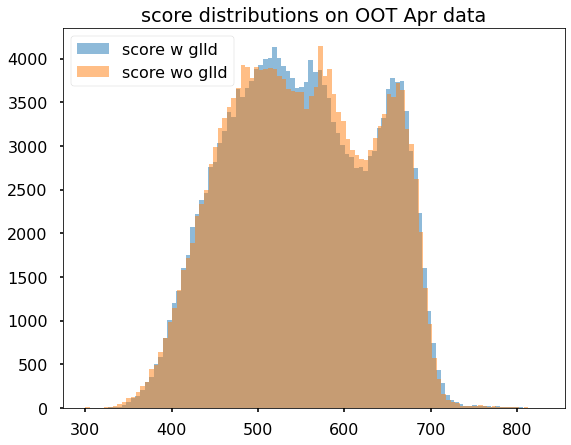

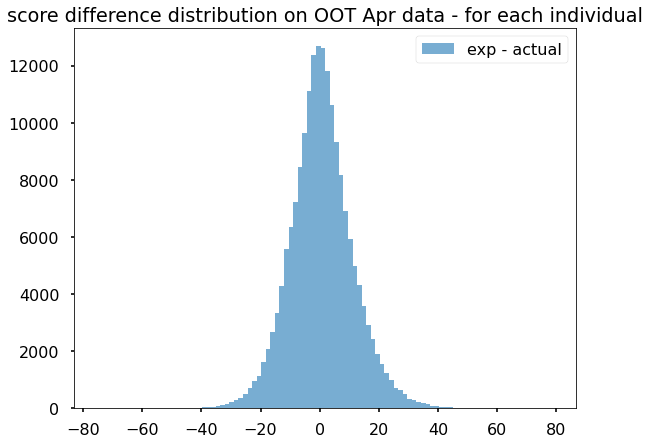

In [5]:
score_dist_plot = plot_score_dist(modeling_df.score_w_glld, 
                                  modeling_df.score_wo_glld, 
                                  bins=100, 
                                  dev_label='score w glld',
                                  prod_label='score wo glld',
                                  title='score distributions on OOT Apr data')
score_diff_plot = plot_difference(modeling_df.score_w_glld, 
                                  modeling_df.score_wo_glld, bins=100, 
                                  title='score difference distribution on OOT Apr data - for each individual')

In [6]:
score_diff_plot.savefig('../../artifacts/without-glld/comparison_score_stats/OOT-apr/oot_score_diff_plot.png')
score_dist_plot.savefig('../../artifacts/without-glld/comparison_score_stats/OOT-apr/oot_score_dist_plot.png')

### Risk Groups

In [7]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])

modeling_df['risk_group_w_glld'] = get_risk_groups(modeling_df.score_w_glld)
modeling_df['risk_group_wo_glld'] = get_risk_groups(modeling_df.score_wo_glld)

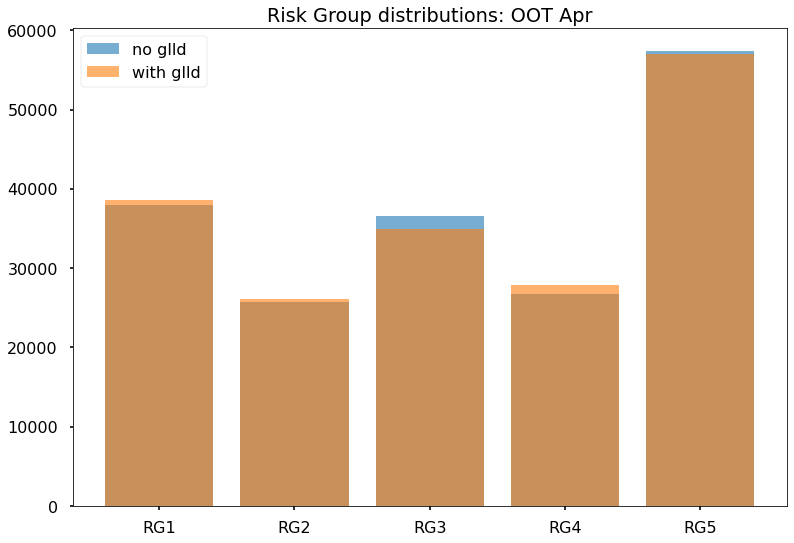

In [8]:
fig = plt.figure()
data = modeling_df.risk_group_w_glld.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='no glld')
data = modeling_df.risk_group_wo_glld.value_counts().sort_index()
plt.bar(data.index, data.values, alpha=0.6, label='with glld')
plt.legend()
plt.title('Risk Group distributions: OOT Apr')
fig.savefig('../../artifacts/without-glld/comparison_score_stats/OOT-apr/oot_risk_group_distr.png')

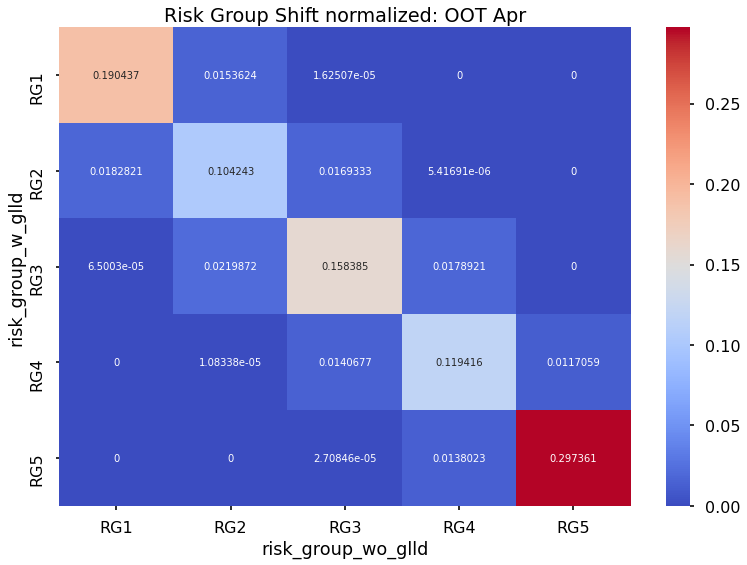

In [9]:
# compare the flow of risk groups
table = modeling_df[['risk_group_w_glld', 'risk_group_wo_glld']].value_counts(normalize=True).sort_index().reset_index()
table.columns = ['risk_group_w_glld', 'risk_group_wo_glld', 'counts']
table = pd.pivot_table(table, values='counts', index='risk_group_w_glld', 
                       columns='risk_group_wo_glld', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift normalized: OOT Apr')
fig.savefig('../../artifacts/without-glld/comparison_score_stats/OOT-apr/oot_RG_shift_norm.png')

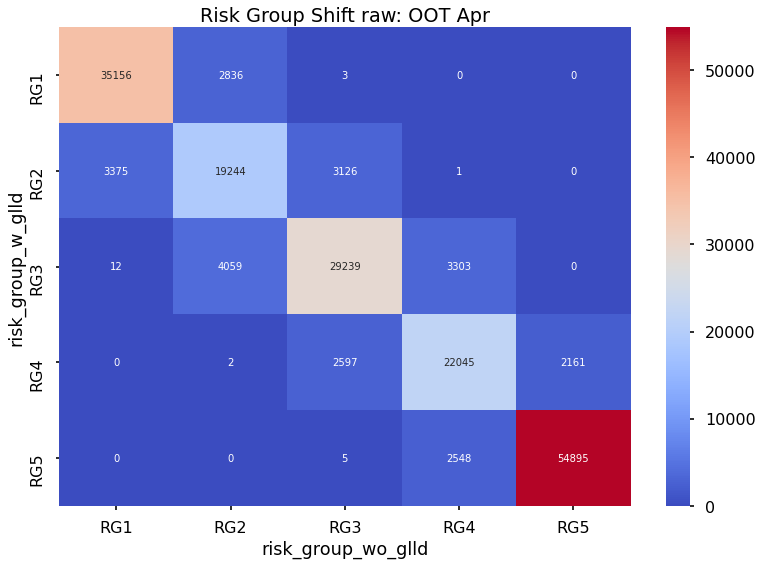

In [10]:
# compare the flow of risk groups
table = modeling_df[['risk_group_w_glld', 'risk_group_wo_glld']].value_counts().sort_index().reset_index()
table.columns = ['risk_group_w_glld', 'risk_group_wo_glld', 'counts']
table = pd.pivot_table(table, values='counts', index='risk_group_w_glld', 
                       columns='risk_group_wo_glld', fill_value=0)
fig = plt.figure()
sns.heatmap(table, cmap='coolwarm', annot=True, fmt='.6g')
plt.title('Risk Group Shift raw: OOT Apr')
fig.savefig('../../artifacts/without-glld/comparison_score_stats/OOT-apr/oot_RG_shift_raw.png')

### Statistic Tables

In [11]:
from rdsutils.plot import plot_pr_curve
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
import gc

def build_table1(modeling_df, percentiles, target_col_name, pred_col_name):
    """ cumulative """
    df = []
    for thresh, pctl in [(np.percentile(modeling_df[pred_col_name], pctl), pctl) for pctl in percentiles]:
        pred = modeling_df[pred_col_name] >= thresh
        rep = classification_report(y_true=modeling_df[target_col_name], y_pred=pred, output_dict=True)
        conf = confusion_matrix(y_true=modeling_df[target_col_name], y_pred=pred)
        tn, fp, fn, tp = conf.ravel()
        df.append([pctl, thresh, fp / (fp + tn) * 100, rep['True']['recall'] * 100,
                  sum(conf[:, 1]), conf[1][1], conf[1][0], conf[0][1], tn])
    return pd.DataFrame(df, columns=['Percentile', 'Threshold', 'False Positive Rate (%)', 
                                     'Fraud Capture Rate (%)', '#Above Threshold', '#Fraudulent Above Threshold', 
                                     '#Fraudulent Below Threshold', '#Good Above Threshold', '#True Negatives'])

def get_metrics(df, score_col):
    dsigma = df[~df['fraud_score_2'].isna()]
    auc = round(roc_auc_score(y_score=dsigma['fraud_score_2'], 
                              y_true=dsigma['target'])*100, 2)
    ap = round(average_precision_score(y_score=dsigma['fraud_score_2'], 
                                       y_true=dsigma['target'])*100, 2)

    print(f'fraud_score_2 alone: {auc}, {ap}')
    del dsigma
    gc.collect()

    dfico = df[~df['fico_score'].isna()]
    auc = round(roc_auc_score(y_score=850-dfico['fico_score'], 
                              y_true=dfico['target'])*100, 2)
    ap = round(average_precision_score(y_score=850-dfico['fico_score'], 
                                       y_true=dfico['target'])*100, 2)

    print(f'fico alone: {auc}, {ap}')
    del dfico
    gc.collect()

    auc = round(roc_auc_score(y_score=df[score_col], 
                              y_true=df['target'])*100, 2)
    ap = round(average_precision_score(y_score=df[score_col], 
                                       y_true=df['target'])*100, 2)

    print(f'model perf: {auc}, {ap}')

#### OOT Stats

In [12]:
df_ = modeling_df[(modeling_df.nr_transactions_next_90d > 0) & (modeling_df.nr_past_transactions > 0)]
get_metrics(df_, 'pred_w_glld')

fraud_score_2 alone: 74.12, 3.17
fico alone: 69.51, 5.72
model perf: 95.76, 41.78


In [13]:
get_metrics(df_, 'pred_wo_glld')

fraud_score_2 alone: 74.12, 3.17
fico alone: 69.51, 5.72
model perf: 95.58, 40.58


#### OOT Tables

In [14]:
table = build_table1(modeling_df, np.linspace(90, 99, 10), 'target', 'pred_wo_glld').round(2)
display(table)
print(table.to_csv(index=False))

,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0,90.0,0.74,9.77,57.61,18462,511,376,17951,165775
1,91.0,0.76,8.78,55.47,16616,492,395,16124,167602
2,92.0,0.78,7.78,53.55,14769,475,412,14294,169432
3,93.0,0.79,6.78,51.75,12923,459,428,12464,171262
4,94.0,0.81,5.79,50.06,11077,444,443,10633,173093
5,95.0,0.82,4.80,47.46,9231,421,466,8810,174916
6,96.0,0.84,3.80,44.64,7385,396,491,6989,176737
7,97.0,0.86,2.81,42.50,5539,377,510,5162,178564
8,98.0,0.88,1.82,39.80,3693,353,534,3340,180386
9,99.0,0.90,0.84,34.27,1847,304,583,1543,182183


Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
90.0,0.74,9.77,57.61,18462,511,376,17951,165775
91.0,0.76,8.78,55.47,16616,492,395,16124,167602
92.0,0.78,7.78,53.55,14769,475,412,14294,169432
93.0,0.79,6.78,51.75,12923,459,428,12464,171262
94.0,0.81,5.79,50.06,11077,444,443,10633,173093
95.0,0.82,4.8,47.46,9231,421,466,8810,174916
96.0,0.84,3.8,44.64,7385,396,491,6989,176737
97.0,0.86,2.81,42.5,5539,377,510,5162,178564
98.0,0.88,1.82,39.8,3693,353,534,3340,180386
99.0,0.9,0.84,34.27,1847,304,583,1543,182183



In [15]:
table = build_table1(modeling_df, np.linspace(0, 90, 10), 'target', 'pred_wo_glld').round(2)
display(table)
print(table.to_csv(index=False))

,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0,0.0,0.00,100.00,100.00,184613,887,0,183726,0
1,10.0,0.00,89.95,99.77,166151,885,2,165266,18460
2,20.0,0.01,79.91,98.99,147690,878,9,146812,36914
3,30.0,0.01,69.87,97.86,129229,868,19,128361,55365
4,40.0,0.03,59.82,96.96,110768,860,27,109908,73818
5,50.0,0.06,49.78,95.26,92307,845,42,91462,92264
6,60.0,0.14,39.75,92.22,73845,818,69,73027,110699
7,70.0,0.28,29.72,87.82,55384,779,108,54605,129121
8,80.0,0.54,19.73,76.10,36923,675,212,36248,147478
9,90.0,0.74,9.77,57.61,18462,511,376,17951,165775


Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0.0,0.0,100.0,100.0,184613,887,0,183726,0
10.0,0.0,89.95,99.77,166151,885,2,165266,18460
20.0,0.01,79.91,98.99,147690,878,9,146812,36914
30.0,0.01,69.87,97.86,129229,868,19,128361,55365
40.0,0.03,59.82,96.96,110768,860,27,109908,73818
50.0,0.06,49.78,95.26,92307,845,42,91462,92264
60.0,0.14,39.75,92.22,73845,818,69,73027,110699
70.0,0.28,29.72,87.82,55384,779,108,54605,129121
80.0,0.54,19.73,76.1,36923,675,212,36248,147478
90.0,0.74,9.77,57.61,18462,511,376,17951,165775



In [16]:
table = build_table1(modeling_df, np.linspace(0, 99, 100), 'target', 'pred_wo_glld').round(2)
display(table)
print(table.to_csv(index=False))

,Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0,0.0,0.00,100.00,100.00,184613,887,0,183726,0
1,1.0,0.00,98.99,100.00,182766,887,0,181879,1847
2,2.0,0.00,97.99,100.00,180920,887,0,180033,3693
3,3.0,0.00,96.99,100.00,179074,887,0,178187,5539
4,4.0,0.00,95.98,100.00,177228,887,0,176341,7385
...,...,...,...,...,...,...,...,...,...
95,95.0,0.82,4.80,47.46,9231,421,466,8810,174916
96,96.0,0.84,3.80,44.64,7385,396,491,6989,176737
97,97.0,0.86,2.81,42.50,5539,377,510,5162,178564
98,98.0,0.88,1.82,39.80,3693,353,534,3340,180386


Percentile,Threshold,False Positive Rate (%),Fraud Capture Rate (%),#Above Threshold,#Fraudulent Above Threshold,#Fraudulent Below Threshold,#Good Above Threshold,#True Negatives
0.0,0.0,100.0,100.0,184613,887,0,183726,0
1.0,0.0,98.99,100.0,182766,887,0,181879,1847
2.0,0.0,97.99,100.0,180920,887,0,180033,3693
3.0,0.0,96.99,100.0,179074,887,0,178187,5539
4.0,0.0,95.98,100.0,177228,887,0,176341,7385
5.0,0.0,94.98,100.0,175382,887,0,174495,9231
6.0,0.0,93.97,100.0,173536,887,0,172649,11077
7.0,0.0,92.97,99.77,171690,885,2,170805,12921
8.0,0.0,91.96,99.77,169844,885,2,168959,14767
9.0,0.0,90.96,99.77,167997,885,2,167112,16614
10.0,0.0,89.95,99.77,166151,885,2,165266,18460
11.0,0.0,88.95,99.77,164305,885,2,163420,20306
12.0,0.0,87.94,99.77,162459,885,2,161574,22152
13.0,0.0,86.94,99.66,160613,884,3,159729,23997
14.0,0.0,85.93,99.66,158767,884,3,157883,25843
15.0,0.0,84.93,99.66,156921,884,3,156037,27689
16.0,0.0,83.92,99.66,155075,884,3,154191,29535
17.0,0.0,82.92,99.66,153228,884,3,152344,

### Build Excel Tables

In [17]:
def build_table_3(modeling_df, percentiles, target_col_name, pred_col_name, fico_col_name):
    """ cumulative """
    df = []
    for (fthresh, pctl), (mthresh, pctl) in zip([(np.percentile(modeling_df[fico_col_name], pctl), pctl) for pctl in percentiles], [(np.percentile(modeling_df[pred_col_name], pctl), pctl) for pctl in percentiles][::-1]):
        mbr = modeling_df[modeling_df[pred_col_name] >= mthresh]['target'].mean() * 100
        fbr = modeling_df[modeling_df[fico_col_name] <= fthresh]['target'].mean() * 100

        df.append([pctl, fthresh, mthresh, fbr, mbr])
        
    return pd.DataFrame(df, columns=['Percentile', 'FICO Threshold', 'Model Score Treshold', 'FICO Bad Rate (%)', 'Model Bad Rate (%)'])

def build_table_4(modeling_df, percentiles, target_col_name, pred_col_name, fico_col_name):
    """ interval """
    df = []
    
    fpctls = [(np.percentile(modeling_df[fico_col_name], pctl), pctl) for pctl in percentiles]
    mpctls = [(np.percentile(modeling_df[pred_col_name], pctl), pctl) for pctl in percentiles][::-1]
    
    for i in range(0, len(fpctls) - 1):
        plo = fpctls[i][-1]
        phi = fpctls[i+1][-1]
        
        mbr = modeling_df[modeling_df[pred_col_name].between(mpctls[i+1][0], mpctls[i][0])]['target'].mean() * 100
        fbr = modeling_df[modeling_df[fico_col_name].between(fpctls[i][0], fpctls[i+1][0])]['target'].mean() * 100

        df.append([f'{plo}-{phi}', fpctls[i][0], mpctls[i+1][0], fbr, mbr])
        
    return pd.DataFrame(df, columns=['Percentile', 'FICO Threshold', 'Model Score Treshold', 'FICO Bad Rate (%)', 'Model Bad Rate (%)'])


def build_table_5(modeling_df, fico_thresholds, model_thresholds, target_col_name, pred_col_name, fico_col_name):
    """ consistent thresholds cumulative """
    df = []
    
    mx = modeling_df[pred_col_name].max()
    model_thresholds = [min(m, mx) for m in model_thresholds]
    
    for fthresh, mthresh in zip(fico_thresholds, model_thresholds):
        mbr = modeling_df[modeling_df[pred_col_name] >= mthresh]['target'].mean() * 100
        fbr = modeling_df[modeling_df[fico_col_name] <= fthresh]['target'].mean() * 100

        df.append([fthresh, mthresh, fbr, mbr])
        
    return pd.DataFrame(df, columns=['FICO Threshold', 'Model Score Treshold', 'FICO Bad Rate (%)', 'Model Bad Rate (%)'])


def build_table_6(modeling_df, fico_thresholds, model_thresholds, target_col_name, pred_col_name, fico_col_name):
    """ consistent thresholds interval """
    df = []
    
    mx = modeling_df[pred_col_name].max()
    model_thresholds = [min(m, mx) for m in model_thresholds]
    
    for i in range(0, len(fico_thresholds) - 1):
        mbr = modeling_df[modeling_df[pred_col_name].between(model_thresholds[i+1], model_thresholds[i], inclusive=True)]['target'].mean() * 100
        
        fbr = modeling_df[modeling_df[fico_col_name].between(fico_thresholds[i], fico_thresholds[i+1], inclusive=True)]['target'].mean() * 100

        df.append([f'{fico_thresholds[i]}-{fico_thresholds[i+1]}', f'{model_thresholds[i+1]}-{model_thresholds[i]}', fbr, mbr])
        
    return pd.DataFrame(df, columns=['FICO Threshold', 'Model Score Treshold', 'FICO Bad Rate (%)', 'Model Bad Rate (%)'])

### Verify - model with glld

In [18]:
fico_thresholds = [0, 479, 552, 582, 605, 630, 652, 671, 688, 702, 715, 726, 735, 743, 751, 759, 765, 772, 779, 786, 794, 801, 809, 818, 830, 850]
model_thresholds = [850, 637, 605, 580, 562, 547, 535, 525, 517, 509, 502, 495, 489, 483, 477, 471, 466, 460, 454, 448, 442, 434, 426, 416, 402, 300]

df_oot = modeling_df

dfixed = df_oot[~df_oot['fico_score'].isna()]
dfixed['fico_adjusted'] = dfixed['fico_score'] * np.where(dfixed['fico_score'] > 850, 0, 1)

tbl = build_table_3(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], np.linspace(0, 100, 26), 'target', 'score_w_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))
print('-'*40)

tbl = build_table_4(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], np.linspace(0, 100, 26), 'target', 'score_w_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))

tbl = build_table_5(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], fico_thresholds, model_thresholds, 'target', 'score_w_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))
print('-'*40)

tbl = build_table_6(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], fico_thresholds, model_thresholds, 'target', 'score_w_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))

print()
print('='*40)
print()

Percentile,FICO Threshold,Model Score Treshold,FICO Bad Rate (%),Model Bad Rate (%)
100.0,0.0,827.59,7.58,100.0
96.0,469.0,635.25,8.0,19.12
92.0,534.0,603.03,7.93,11.59
88.0,571.0,576.99,6.67,8.18
84.0,593.0,557.9,5.42,6.36
80.0,616.0,542.16,4.69,5.13
76.0,640.0,529.36,3.97,4.32
72.0,661.0,518.45,3.51,3.74
68.0,678.0,508.98,3.13,3.28
64.0,694.0,500.82,2.8,2.95
60.0,708.0,493.39,2.55,2.66
56.0,719.0,486.48,2.35,2.44
52.0,729.0,480.0,2.15,2.23
48.0,738.0,474.09,2.01,2.08
44.0,747.0,468.14,1.87,1.93
40.0,755.0,462.72,1.75,1.81
36.0,762.0,457.22,1.65,1.7
32.0,769.0,451.61,1.55,1.6
28.0,776.0,445.69,1.48,1.51
24.0,783.0,439.68,1.41,1.43
20.0,791.0,433.15,1.34,1.36
16.0,798.0,426.38,1.28,1.3
12.0,807.0,418.45,1.23,1.24
8.0,817.0,408.83,1.18,1.18
4.0,829.0,394.16,1.13,1.13
0.0,850.0,300.0,1.09,1.09

----------------------------------------
Percentile,FICO Threshold,Model Score Treshold,FICO Bad Rate (%),Model Bad Rate (%)
0.0-4.0,0.0,635.25,8.0,19.12
4.0-8.0,469.0,603.03,7.91,4.05
8.0-12.0,53

In [19]:
fico_thresholds = [0, 479, 552, 582, 605, 630, 652, 671, 688, 702, 715, 726, 735, 743, 751, 759, 765, 772, 779, 786, 794, 801, 809, 818, 830, 850]
model_thresholds = [850, 637, 605, 580, 562, 547, 535, 525, 517, 509, 502, 495, 489, 483, 477, 471, 466, 460, 454, 448, 442, 434, 426, 416, 402, 300]

df_oot = modeling_df

dfixed = df_oot[~df_oot['fico_score'].isna()]
dfixed['fico_adjusted'] = dfixed['fico_score'] * np.where(dfixed['fico_score'] > 850, 0, 1)

tbl = build_table_3(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], np.linspace(0, 100, 26), 'target', 'score_wo_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))
print('-'*40)

tbl = build_table_4(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], np.linspace(0, 100, 26), 'target', 'score_wo_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))

tbl = build_table_5(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], fico_thresholds, model_thresholds, 'target', 'score_wo_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))
print('-'*40)

tbl = build_table_6(dfixed[(dfixed['nr_transactions_next_90d'] > 0) & (dfixed['nr_past_transactions'] > 0)], fico_thresholds, model_thresholds, 'target', 'score_wo_glld', 'fico_adjusted')
print(tbl.round(2).to_csv(index=False))

print()
print('='*40)
print()

Percentile,FICO Threshold,Model Score Treshold,FICO Bad Rate (%),Model Bad Rate (%)
100.0,0.0,824.99,7.58,100.0
96.0,469.0,636.66,8.0,19.07
92.0,534.0,604.05,7.93,11.45
88.0,571.0,578.16,6.67,8.11
84.0,593.0,558.53,5.42,6.34
80.0,616.0,543.02,4.69,5.13
76.0,640.0,530.17,3.97,4.31
72.0,661.0,519.48,3.51,3.73
68.0,678.0,510.01,3.13,3.28
64.0,694.0,501.88,2.8,2.93
60.0,708.0,494.47,2.55,2.64
56.0,719.0,487.53,2.35,2.43
52.0,729.0,481.59,2.15,2.22
48.0,738.0,475.46,2.01,2.06
44.0,747.0,469.65,1.87,1.93
40.0,755.0,464.01,1.75,1.81
36.0,762.0,458.53,1.65,1.7
32.0,769.0,452.79,1.55,1.6
28.0,776.0,447.14,1.48,1.51
24.0,783.0,441.03,1.41,1.43
20.0,791.0,434.3,1.34,1.36
16.0,798.0,427.27,1.28,1.3
12.0,807.0,418.86,1.23,1.24
8.0,817.0,408.64,1.18,1.18
4.0,829.0,393.23,1.13,1.13
0.0,850.0,300.0,1.09,1.09

----------------------------------------
Percentile,FICO Threshold,Model Score Treshold,FICO Bad Rate (%),Model Bad Rate (%)
0.0-4.0,0.0,636.66,8.0,19.07
4.0-8.0,469.0,604.05,7.91,3.84
8.0-12.0,5